In [1]:
import numpy as np
import pandas as pd
from utils import equilibrium
import matplotlib.pyplot as plt
%matplotlib inline

# Data Input

### Species

In [2]:
species = pd.read_excel('UW PokéDex GO.xlsx', sheet_name='0.0.1 Pokémon Dex Data', header=1, nrows=453, index_col='Shorthand' 
                       , skiprows=[163], usecols=[4, 9, 16, 17, 19, 20, 21], names=['Final', 'Type1','Type2','Atk','Def','Sta'])
species = species.rename(index={'Shorthand': 'Name'})
species = species.fillna('Empty')
species.Atk += 15
species.Def += 15
species.Sta += 15

### Pokemon Moves

In [3]:
species_moves = pd.read_excel('UW PokéDex GO.xlsx', sheet_name='0.1.1 Pokémon GO Moves', header=1, nrows=392
                             , skiprows=[133], usecols=[1, 2, 3, 4, 5, 6])

### Moves

In [4]:
moves = pd.read_excel('UW PokéDex GO.xlsx', sheet_name='0.1.2 Attack Dex (GO)', header=0, usecols=[0, 1, 2, 4, 5, 7]
                     , index_col='Move', names=['Type', 'Fast', 'Power', 'Energy', 'Duration'])
moves.Duration /= 1000

### Type effectiveness

In [5]:
effi = pd.read_excel('UW PokéDex GO.xlsx', sheet_name='0.3.1 Type Table', header=0
                     , usecols=[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]).T
effi **= np.log(1.6) / np.log(1.4)

### Gym permitted 

In [87]:
gym = pd.read_csv('gym.csv', header=0, usecols=[1, 2], index_col='Name')

# Data Transform

In [8]:
pokemon = pd.read_csv("stats.csv", sep='\t', nrows=0)

for i in range(len(species_moves)):
    if species.loc[species_moves.Pokémon[i], "Final"]:
        for j in range(1, 3):
            if pd.notna(species_moves.iloc[i, j]):
                for k in range(3, 6):
                    if pd.notna(species_moves.iloc[i, k]):
                        pokemon = pokemon.append(species.loc[species_moves.Pokémon[i]])
                        pokemon.ix[-1, 'Name'] = pokemon.index[-1]
                        pokemon.ix[-1, 'Fast'] = species_moves.iloc[i, j]
                        pokemon.ix[-1, 'Charge'] = species_moves.iloc[i, k]
                        pokemon.ix[-1, 'Type_F'] = moves.loc[pokemon.iloc[-1].Fast].Type
                        pokemon.ix[-1, 'Type_C'] = moves.loc[pokemon.iloc[-1].Charge].Type
                        pokemon.ix[-1, 'Power1'] = moves.loc[pokemon.iloc[-1].Fast].Power
                        pokemon.ix[-1, 'Energy1'] = moves.loc[pokemon.iloc[-1].Fast].Energy
                        pokemon.ix[-1, 'Time1'] = moves.loc[pokemon.iloc[-1].Fast].Duration
                        pokemon.ix[-1, 'Stab1'] = 1.2 if pokemon.iloc[-1].Type_F in (pokemon.iloc[-1].Type1, pokemon.iloc[-1].Type2) else 1
                        pokemon.ix[-1, 'Power2'] = moves.loc[pokemon.iloc[-1].Charge].Power
                        pokemon.ix[-1, 'Energy2'] = moves.loc[pokemon.iloc[-1].Charge].Energy
                        pokemon.ix[-1, 'Time2'] = moves.loc[pokemon.iloc[-1].Charge].Duration
                        pokemon.ix[-1, 'Stab2'] = 1.2 if pokemon.iloc[-1].Type_C in (pokemon.iloc[-1].Type1, pokemon.iloc[-1].Type2) else 1                   

/home/zheng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.
/home/zheng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()
/home/zheng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-inde

# Payoff matrix

In [76]:
attack = pokemon.loc[gym.Gym == 1]
defend = species.loc[gym[gym.Gym == 1].index]
defend = defend[defend.Final == 1]
m, n = len(attack), len(defend) 
payoff = np.zeros((m, n))

### Computation

In [77]:
for i in range(m):
    for j in range(n):
        attacker, defender = attack.iloc[i], defend.iloc[j]
        attacker_stats = attacker.Atk
        defender_stats = defender.Def * defender.Sta

        fast_damage = attacker.Power1 * attacker.Stab1 * effi.loc[attacker.Type_F, defender.Type1] * effi.loc[attacker.Type_F, defender.Type2]
        charge_damage= attacker.Power2 * attacker.Stab2 * effi.loc[attacker.Type_C, defender.Type1] * effi.loc[attacker.Type_C, defender.Type2]
        weight = attacker.Energy1 / attacker.Energy2
        attacker_dps = (fast_damage + weight * charge_damage) / (attacker.Time1 + weight * attacker.Time2)
        attacker_dps = max(attacker_dps, fast_damage / attacker.Time1)
        
#        fast_damage = defender.Power1 * defender.Stab1 * effi.loc[defender.Type_F, attacker.Type1] * effi.loc[defender.Type_F, attacker.Type2]
#        charge_damage= defender.Power2 * defender.Stab2 * effi.loc[defender.Type_C, attacker.Type1] * effi.loc[defender.Type_C, attacker.Type2]
#        weight = defender.Energy1 / defender.Energy2
#        defender_dps = (fast_damage + weight * charge_damage) / (defender.Time1 + 2 + weight * (defender.Time2 + 2))
                        
        payoff[i, j] = - defender_stats / attacker_stats / attacker_dps

### Visualization

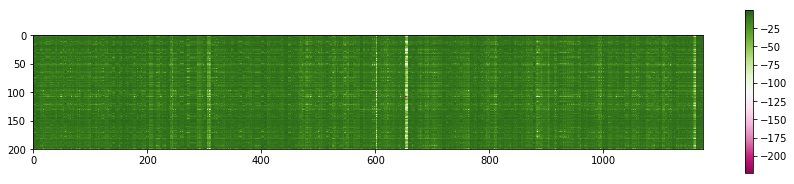

In [85]:
plt.figure(figsize=(15, 3))
plt.imshow(payoff.T, cmap='PiYG')
plt.colorbar()

# Equilibrium

### Calculate the equlibrium

In [79]:
p, q = equilibrium(payoff, 10000)
p[abs(p)<0.01] = 0
q[abs(q)<0.01] = 0

### Attacker list

In [80]:
dfp = attack.iloc[p.nonzero()].copy()
dfp['Weight'] = p[p.nonzero()]
dfp

,Name,Type1,Type2,Atk,Def,Sta,Fast,Type_F,Power1,Energy1,Time1,Stab1,Charge,Type_C,Power2,Energy2,Time2,Stab2,Final,Weight
Blaziken,Blaziken,Fire,Fighting,255,156,205,Counter,Fighting,12.0,8.0,0.9,1.2,Overheat,Fire,160.0,100.0,4,1.2,1.0,0.625540
Breloom,Breloom,Grass,Fighting,256,159,170,Counter,Fighting,12.0,8.0,0.9,1.2,Dynamic Punch,Fighting,90.0,50.0,2.7,1.2,1.0,0.254823
Salamence,Salamence,Dragon,Flying,292,183,231,Dragon Tail,Dragon,15.0,9.0,1.1,1.2,Draco Meteor,Dragon,150.0,100.0,3.6,1.2,1.0,0.119631


### Defender list

In [81]:
dfq = defend.iloc[q.nonzero()].copy()
dfq['Weight'] = q[q.nonzero()]
dfq

,Final,Type1,Type2,Atk,Def,Sta,Weight
Name,,,,,,,
Dragonite,1,Dragon,Flying,278,213,224,0.232471
Blissey,1,Normal,Empty,144,184,511,0.607077
Gardevoir,1,Psychic,Fairy,252,210,184,0.160451


### File output

In [64]:
with open('metalist.txt', 'w') as f:
    f.write('--------Attack List---------\n')
    f.write(dfp.to_csv())
    f.write('--------Defend List---------\n')
    f.write(dfq.to_csv())